# Parallelisierung
Bei der Programmierung benutzerdefinierter Algorithmen in Python kann es vorkommen, dass unser Code langsam wird, weil wir einige verschachtelte For-Schleifen ausführen. Wenn die inneren Schleifen nicht voneinander abhängen, kann der Code parallelisiert und beschleunigt werden. Beachten Sie, dass wir Code auf einer zentralen Verarbeitungseinheit (CPU) parallelisieren und verwechseln Sie dies nicht mit GPU-Beschleunigung, die Grafikprozessoren (GPUs) verwendet.

Siehe auch
* [Scikit-image Parallelisierungs-Tutorial](https://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html)

In [1]:
import time
import numpy as np
from functools import partial
import timeit
import matplotlib.pyplot as plt
import platform

Wir beginnen mit einem Algorithmus, der etwas mit einem Bild an bestimmten Pixelkoordinaten macht

In [2]:
def slow_thing(image, x, y):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(1000):
        for j in range(100):
            sum = sum + x
        sum = sum + y
    image[x, y] = sum

image = np.zeros((10, 10))

Wir verwenden jetzt [timeit](https://docs.python.org/3/library/timeit.html), um zu messen, wie lange die Operation für die Verarbeitung eines einzelnen Pixels dauert.

In [3]:
%timeit slow_thing(image, 4, 5)

3.3 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Wir definieren jetzt die Operation für das gesamte Bild und messen die Zeit dieser Funktion.

In [4]:
def process_image(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            slow_thing(image, x, y)

In [5]:
%timeit process_image(image)

353 ms ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Diese Funktion ist ziemlich langsam und eine Parallelisierung könnte sinnvoll sein.

## Parallelisierung mit joblib.Parallel
Ein einfacher und direkter Ansatz zur Parallelisierung ist die Verwendung von [`joblib.Parallel`](https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html) und `joblib.delayed`.

In [6]:
from joblib import Parallel, delayed, cpu_count

Beachten Sie die umgekehrte Schreibweise der For-Schleifen im folgenden Block. Der Ausdruck `delayed(slow_thing)(image, x, y)` ist technisch gesehen ein Funktionsaufruf, der nicht ausgeführt wird. Erst später, wenn der Rückgabewert dieses Aufrufs tatsächlich benötigt wird, erfolgt die eigentliche Ausführung. Siehe [dask delayed](https://docs.dask.org/en/stable/delayed.html) für Details.

In [7]:
def process_image_parallel(image):
    Parallel(n_jobs=-1)(delayed(slow_thing)(image, x, y) 
                        for y in range(image.shape[0]) 
                        for x in range(image.shape[1]))

In [8]:
%timeit process_image_parallel(image)

62.4 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Eine Beschleunigung um den Faktor 7 ist nicht schlecht. Das `n_jobs=-1` bedeutet, dass alle Recheneinheiten / Threads verwendet werden. Wir können auch ausgeben, wie viele Rechenkerne verwendet wurden:

In [9]:
cpu_count()

16

Zu Dokumentationszwecken können wir auch ausgeben, auf welcher Art von CPU dieser Algorithmus ausgeführt wurde. Diese Zeichenfolge kann je nach Betriebssystem / Computer, auf dem wir dieses Notebook ausführen, mehr oder weniger informativ sein.

In [10]:
platform.processor()

'AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD'

## Benchmarking der Ausführungszeit
In der Bildverarbeitung ist es sehr üblich, dass die Ausführungszeit von Algorithmen je nach Bildgröße unterschiedliche Muster aufweist. Wir werden jetzt den obigen Algorithmus benchmarken und sehen, wie er bei verschiedenen Bildgrößen abschneidet.
Um eine zu benchmarkende Funktion an ein gegebenes Bild zu binden, ohne sie auszuführen, verwenden wir das [partial](https://docs.python.org/3/library/functools.html#functools.partial) Muster.

In [11]:
def benchmark(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 5) * 10

    benchmark_data = []

    for size in sizes:
        print("Size", size)

        # make new data
        image = np.zeros((size, size))
        
        # bind target function to given image
        partial_function = partial(target_function, image)

        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        print("time", time_in_s, "s")

        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

In [12]:
print("Benchmarking normal")
benchmark_data_normal = benchmark(process_image)
print("Benchmarking parallel")
benchmark_data_parallel = benchmark(process_image_parallel)

Benchmarking normal
Size 10
time 3.5427859 s
Size 20
time 13.8465019 s
Size 30
time 30.883478699999998 s
Size 40
time 55.4255712 s
Benchmarking parallel
Size 10
time 0.7873560999999967 s
Size 20
time 2.0985788000000127 s
Size 30
time 4.9782009000000045 s
Size 40
time 7.9171936000000045 s


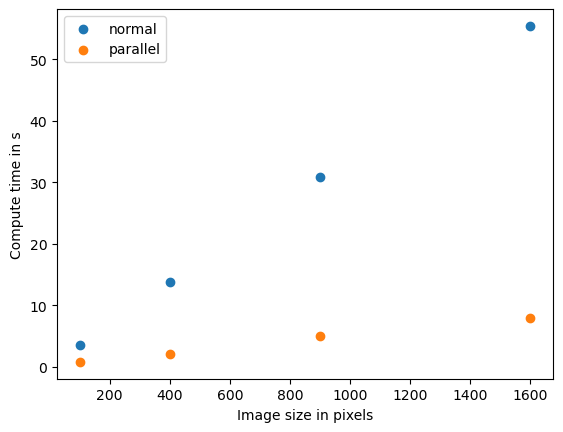

In [13]:
plt.scatter(benchmark_data_normal[:,0] ** 2, benchmark_data_normal[:,1])
plt.scatter(benchmark_data_parallel[:,0] ** 2, benchmark_data_parallel[:,1])
plt.legend(["normal", "parallel"])
plt.xlabel("Bildgröße in Pixeln")
plt.ylabel("Rechenzeit in s")
plt.show()

Wenn wir dieses Muster sehen, sprechen wir von einer _linearen_ Beziehung zwischen Datengröße und Rechenzeit. Informatiker verwenden die [O-Notation](https://de.wikipedia.org/wiki/Landau-Symbole), um die [Komplexität](https://de.wikipedia.org/wiki/Komplexit%C3%A4tstheorie_(Informatik)) von Algorithmen zu beschreiben. Dieser Algorithmus hat `O(n)`, wobei `n` in diesem Fall die Anzahl der Pixel darstellt.

## Qualitätssicherung
Beachten Sie, dass wir in diesem Abschnitt nur die Rechenzeit von Algorithmen gemessen haben. Wir haben nicht festgestellt, ob die unterschiedlich optimierten Versionen der Algorithmen das gleiche Ergebnis produzieren. Qualitätssicherung ist gute wissenschaftliche Praxis. Das Gleiche gilt im Kontext der GPU-Beschleunigung und wird zum Beispiel [hier](https://arxiv.org/pdf/2008.11799) detailliert beschrieben.